In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import air_traff_utils as atu
from sklearn import preprocessing

import ipdb

In [2]:
atu.setup_seed(12)

In [3]:
def plot_tensor_quick(tensor):
#     plt.figure()
    try:
        plt.plot(tensor.cpu().detach().numpy())
    except Exception as e:
        plt.plot(tensor.detach().numpy())

# Loading Data

In [359]:
us_CSA = pd.read_csv('./data/us_CSA.csv', index_col=0)
OD_df = pd.read_csv('./outputs/201904_OD_CSA.csv', index_col=0).sort_index(axis=0).sort_index(axis=1)
CSA_df = pd.read_csv('./data/CSA_df.csv')

In [360]:
us_CSA_use = us_CSA.loc[us_CSA['if_plot']==1]
print(us_CSA_use.shape)
us_CSA_use.head(2)

(24, 26)


,TotPop,CSA,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageW,E_MedWageW,...,D4C,D4D,D5AR,D5AE,NatWalkInd,INTPTLAT,INTPTLON,CSA_Name,if_plot,geometry
6,6584708,122.0,29300.0,"LaGrange, GA-AL",142257,759558,1449909,2970375,668868,969644,...,-60276.863137,-60268.179268,310871248,224466891,8.498581,33.834001,-84.305803,"Atlanta--Athens-Clarke County--Sandy Springs, ...",1,"POLYGON ((-85.165852 32.808496999999996, -85.1..."
13,8200935,148.0,49340.0,"Worcester, MA-CT",349774,1079810,1704849,3823517,825804,1051349,...,-28799.664050,-28642.284283,646668796,596458073,11.342761,42.293282,-71.237945,"Boston-Worcester-Providence, MA-RI-NH-CT",1,"MULTIPOLYGON (((-71.883921 41.326498, -71.8821..."


In [361]:
data_X_df = pd.DataFrame(us_CSA_use.copy().drop(['CSA', 'CBSA', 'CBSA_Name', 'geometry', 'if_plot'], axis=1))
data_X_df.index = range(data_X_df.shape[0])


In [362]:
data_X_df['CSA_Code'] = ''
for i in data_X_df.index:
    CSA_Name = data_X_df.loc[i, 'CSA_Name']
    data_X_df.loc[i, 'CSA_Code'] = CSA_df.loc[CSA_df['CSA_Name']==CSA_Name, 'Airport'].values[0]

data_X_df = data_X_df[['TotPop', 'D3A', 'D4A', 'D4C', 'INTPTLAT', 'INTPTLON', 'CSA_Name', 'CSA_Code']]
print(data_X_df.shape)
data_X_df.head(2)

(24, 8)


,TotPop,D3A,D4A,D4C,INTPTLAT,INTPTLON,CSA_Name,CSA_Code
0,6584708,11.808044,-67955.508346,-60276.863137,33.834001,-84.305803,"Atlanta--Athens-Clarke County--Sandy Springs, ...",ATL
1,8200935,18.586822,-39255.813819,-28799.664050,42.293282,-71.237945,"Boston-Worcester-Providence, MA-RI-NH-CT",BOS


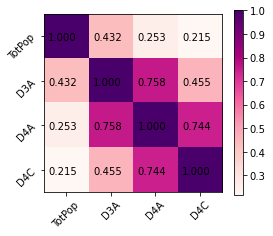

In [363]:
plt.figure(figsize=[data_X_df.shape[1]-4,data_X_df.shape[1]-4])
heat_plot_data_X_df = data_X_df.iloc[:, :data_X_df.shape[1]-4]
plt.imshow(heat_plot_data_X_df.corr(), cmap='RdPu')
for i in range(data_X_df.shape[1]-4):  # 18 features, number may subject to change
    for j in range(data_X_df.shape[1]-4):
        plt.text(i-0.4, j+0.1, '%.3f'%(heat_plot_data_X_df.corr().iloc[i, j]))
plt.xticks(range(data_X_df.shape[1]-4), list(heat_plot_data_X_df.columns), rotation = 45)
plt.yticks(range(data_X_df.shape[1]-4), list(heat_plot_data_X_df.columns), rotation = 45)
plt.colorbar(shrink=0.85)

(24, 24)


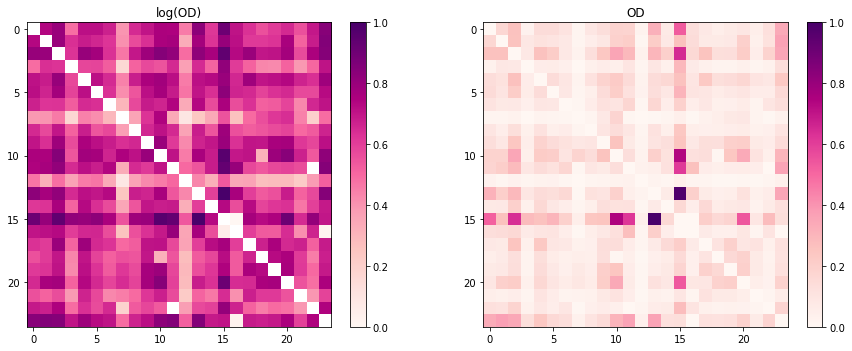

In [364]:
print(OD_df.shape)
fig = plt.figure(figsize=[15,7])

ax1 = fig.add_subplot(121)
ax1.imshow(np.log(OD_df), cmap='RdPu')
ax1.set_title('log(OD)')
fig.colorbar(cm.ScalarMappable(cmap='RdPu'), ax=ax1, shrink=0.8)

ax2 = fig.add_subplot(122)
ax2.imshow(OD_df, cmap='RdPu')
ax2.set_title('OD')
fig.colorbar(cm.ScalarMappable(cmap='RdPu'), ax=ax2, shrink=0.8)


# Prepare Feature Pairs
## For each OD pair in the OD matrix, it has its feature combination, [feature of loc1, feature of loc2, distance]

In [365]:
def GCDistance(S_Lat,S_Lon,E_Lat,E_Lon):
    start_lat = np.radians(S_Lat)  
    start_lon = np.radians(S_Lon)
    end_lat = np.radians(E_Lat)
    end_lon = np.radians(E_Lon)
    d_lat = end_lat - start_lat  
    d_lon = end_lon - start_lon  
    a = np.sin(d_lat/2)**2 + np.cos(start_lat) * np.cos(end_lat) * np.sin(d_lon/2)**2  
    c = 2 * np.arcsin(np.sqrt(a))  
    # Radius of earth is 3440 nm
    return 3440 * c

In [366]:
def get_data_X_OD(data_X):
    num_cities = CSA_df.shape[0]
    data_X_OD = np.zeros([num_cities*num_cities, (data_X.shape[1]-4)*2+1])  # 4 features, may subject to change
    for i in range(CSA_df.shape[0]):
        org = CSA_df.loc[i, 'Airport']
        S_Lat = CSA_df.loc[i, 'lat']
        S_Lon = CSA_df.loc[i, 'lon']
        for j in range(CSA_df.shape[0]):
            dest = CSA_df.loc[j, 'Airport']
            feature_org = data_X.loc[data_X['CSA_Code']==org].values.flatten()[:(data_X.shape[1]-4)]
            feature_dest = data_X.loc[data_X['CSA_Code']==dest].values.flatten()[:(data_X.shape[1]-4)]
            feature = np.append(feature_org, feature_dest)
            
            E_Lat = CSA_df.loc[j, 'lat']
            E_Lon = CSA_df.loc[j, 'lon']
            distance = GCDistance(S_Lat,S_Lon,E_Lat,E_Lon)  # Great Circle Distance, unit: [nm]
            
            data_X_OD[i*num_cities+j, :] = np.append(feature, distance)
        
    # preprocessing.StandardScaler(), see:
    # https://scikit-learn.org/stable/modules/preprocessing.html
    scalar = preprocessing.StandardScaler().fit(data_X_OD)
    data_X_OD_norm = scalar.transform(data_X_OD)
    
    return scalar, data_X_OD_norm


In [367]:
def get_logOD(OD):
    # OD is originally DataFrame
    OD = np.array(OD)
    for i in range(OD.shape[0]):
        for j in range(OD.shape[1]):
            if OD[i, j]!=0:
                OD[i, j] = np.log(OD[i, j])
    return OD

In [368]:
scalar_data_X, data_X = get_data_X_OD(data_X_df)  # shape: [num_cities * num_cities, num_features*2+1]
print('data_X | Shape:', data_X.shape, ', type: %s'%type(data_X))

OD = np.array(OD_df)  # shape: [num_cities, num_cities]
OD = OD.reshape(-1, 1)
scalar_OD = preprocessing.MinMaxScaler().fit(OD)
OD = scalar_OD.transform(OD)
print('OD | Shape:', OD.shape, ', type: %s'%type(OD))

data_X | Shape: (576, 9) , type: <class 'numpy.ndarray'>
OD | Shape: (576, 1) , type: <class 'numpy.ndarray'>


# Define VAE Model Structure

In [369]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import TensorDataset

In [471]:
# Model specification
class VAD_FC_Net(nn.Module):
    def __init__(self, in_out_size, feature_dim, dropout_p=0.0):
        super(VAD_FC_Net, self).__init__()
        self.in_out_size = in_out_size
        self.feature_dim = feature_dim
        self.dropout_p = dropout_p
        
        self.encoder1 = nn.Sequential(
            nn.Linear(in_out_size, 32),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(32, 32),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(32, 32),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(32, 32),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
        )
        
        self.encoder21 = nn.Sequential(
            nn.Linear(16, 16),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(16, feature_dim),
            nn.Dropout(dropout_p)
        )
        self.encoder22 = nn.Sequential(
            nn.Linear(16, 16),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(16, feature_dim),
            nn.Dropout(dropout_p),
        )
        
        self.decoder1 = nn.Sequential(
            nn.Linear(feature_dim, 16),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(16, 16),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
        )
        self.decoder2 = nn.Sequential(
            nn.Linear(16, 32),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(32, 32),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(32, 32),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(32, 32),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(32, in_out_size),
            nn.LeakyReLU()
        )
        
        
    def forward(self, x):
        # shape of x: [batch, ]
#         ipdb.set_trace()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        x = self.encode(x)
        # shape of "x" here = [batch, feature_dim]
        hidden_mean, log_hidden_var = self.reparm(x)
        
        # sampling process
        std = log_hidden_var.mul(0.5).exp_()
        eps = torch.autograd.Variable(std.data.new(std.size()).normal_())
        sampled_feature = hidden_mean + eps.mul(std)
        
        y = self.decode(sampled_feature)  # vae
#         y = self.decode(hidden_mean)  # ae

        return hidden_mean, log_hidden_var, y
    
    def encode(self, x):
        x = self.encoder1(x)
        return x
    
    def reparm(self, x):
        hidden_mean = self.encoder21(x)
        log_hidden_var = self.encoder22(x)
        return hidden_mean, log_hidden_var
        
    def decode(self, x):        
        y = self.decoder2(self.decoder1(x))
        return y
    
        
    

# Preparing data for PyTorch

In [472]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# OD = torch.tensor(OD, dtype=torch.float32, device=device, requires_grad=True)
# data_X_OD = torch.tensor(data_X_OD, dtype=torch.float32, device=device, requires_grad=True)

prop = 0.5
l = int(prop*OD.shape[0])

OD_train = torch.tensor(OD[:l, :], dtype=torch.float32, device=device, requires_grad=True)
OD_val = torch.tensor(OD[l:, :], dtype=torch.float32, device=device, requires_grad=True)
data_X_train = torch.tensor(data_X[:l, :], dtype=torch.float32, device=device, requires_grad=True)
data_X_val = torch.tensor(data_X[l:, :l], dtype=torch.float32, device=device, requires_grad=True)

print('OD_train', type(OD_train), OD_train.shape)
print('OD_val', type(OD_val), OD_val.shape)
print('data_X_train', type(data_X_train), data_X_train.shape)
print('data_X_val', type(data_X_val), data_X_val.shape)

OD_train <class 'torch.Tensor'> torch.Size([288, 1])
OD_val <class 'torch.Tensor'> torch.Size([288, 1])
data_X_train <class 'torch.Tensor'> torch.Size([288, 9])
data_X_val <class 'torch.Tensor'> torch.Size([288, 9])


## Define KL Divergence between two Gaussian Distributions
<img src="./imgs/KL.png" width="500">
Note that $\sigma_2=1$

In [473]:
def KL_loss(mean1, logvar1, mean2):
    # mean1, std1, mean2, std2 are 2-D matrices (type: tensor)
    # the first dimension is batch size, 
    # the second is number of variables
    
    # mean1, std1 are mean, std of predicted value
    # mean2, std2 are mean, std of true value, std2=1
    # 1 and 2 are irreversible
    
    assert mean1.shape[0] == mean2.shape[0]
    assert mean1.shape[1] == mean2.shape[1]
#     ipdb.set_trace()
    KL_div = -0.5*(logvar1 - logvar1.exp() - (mean1 - mean2)**2 + 1).mean(axis=1).mean()
    
    return KL_div  # depends on the reconstruction loss reduction (either sum or mean)

# Initialize the Model

In [474]:
# Train the model by inputing 
# flattened OD matrix
# to the model, then output the hidden feature and the reconstructed OD matrix
model = VAD_FC_Net(in_out_size=1, feature_dim=data_X_train.shape[-1]).to(device)
loss_recon = nn.MSELoss()  # reconstruction loss function

loss_set_recons = []
loss_set_KL = []
loss_set_train = []
loss_set_val = []

print('There are %i OD pairs'%OD.shape[0])
print('Input shape is', data_X_train.shape[-1])

There are 576 OD pairs
Input shape is 9


In [475]:
# summary(model) 

# Train the Model

In [476]:
optimizer = optim.Adam(model.parameters())
# optimizer = optim.SGD(model.parameters(), lr=0.01)

In [477]:
gen_mean, log_hidden_var, out = model(OD_train)
# out

In [486]:
model.train()
X = OD_train
true_mean = data_X_train

epochs = 200
   
for e in range(epochs+1):
    #ipdb.set_trace()

    gen_mean, log_hidden_var, out = model(X)
#     out1 = model.encode(X)
#     gen_mean, log_hidden_var = model.reparm(out1)
    
    loss_re = loss_recon(out, X)
    loss_KL = KL_loss(gen_mean, log_hidden_var, true_mean)
#     loss_KL = ((gen_mean - true_mean)**2).sum(axis=1).mean()  # mmd loss
    loss = loss_re + loss_KL

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    out_val = model.decoder2(model.decoder1(data_X_val))
#         ipdb.set_trace()
    loss_val = loss_recon(out_val, OD_val)

    loss_set_val.append(loss_val.cpu().detach().numpy())
    loss_set_train.append(loss.cpu().detach().numpy())
    loss_set_recons.append(loss_re.cpu().detach().numpy())
    loss_set_KL.append(loss_KL.cpu().detach().numpy())

    if e%100==0:

        # print the information of epoch e, the last mini-batch
        print('Epoch %i   success, gen loss:%.6f, reconstruction loss:%.6f, KL loss:%.8f, '%(
            e, loss_val.cpu().detach().numpy(), loss_re.cpu().detach().numpy(), loss_KL.cpu().detach().numpy()
        ))
        

Epoch 0   success, gen loss:0.014819, reconstruction loss:0.007294, KL loss:0.53269279, 
Epoch 100   success, gen loss:0.015126, reconstruction loss:0.007123, KL loss:0.52957070, 
Epoch 200   success, gen loss:0.015368, reconstruction loss:0.008122, KL loss:0.52577996, 


In [487]:
def plot_loss(gen, train, recons, KL, title):
    fig = plt.figure(figsize=[16,5])
    ax1 = fig.add_subplot(141)
    ax1.plot(gen)
    ax1.set_xlabel('Epoches/100')
    ax1.set_ylabel('MSELoss')
    ax1.set_ylim([0, max(gen)])
    ax1.set_title('Generation loss')
    ax1.grid()
    ax2 = fig.add_subplot(142)
    ax2.plot(train)
    ax2.set_xlabel('Epoches/100')
    ax2.set_ylabel('MSELoss')
    ax2.set_ylim([0, max(train)])
    ax2.set_title('Training loss')
    ax2.grid()
    ax3 = fig.add_subplot(143)
    ax3.plot(recons)
    ax3.set_xlabel('Epoches/100')
    ax3.set_ylabel('MSELoss')
    ax3.set_ylim([0, max(recons)])
    ax3.set_title('Reconstruction loss')
    ax3.grid()
    ax4 = fig.add_subplot(144)
    ax4.plot(KL)
    ax4.set_xlabel('Epoches/100')
    ax4.set_ylabel('MSELoss')
    ax4.set_ylim([0, max(KL)])
    ax4.set_title('KL loss')
    ax4.grid()
    
    plt.suptitle(title)

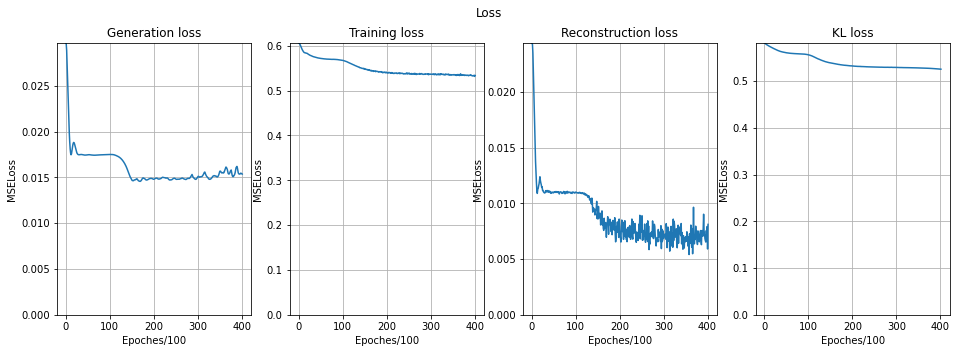

In [488]:
plot_loss(loss_set_val, loss_set_train, loss_set_recons, loss_set_KL, 'Loss')

In [489]:
gen = model.decode(data_X_val).cpu().detach().numpy().copy()

# x = model.encode(OD_val)
# hidden_mean, log_hidden_var = model.reparm(x)
# std = log_hidden_var.mul(0.5).exp_()

# gen_up = model.decoder2(model.decoder1(data_X_train+std)).cpu().detach().numpy().copy()
# gen_low = model.decoder2(model.decoder1(data_X_train-std)).cpu().detach().numpy().copy()

labels = OD_val.cpu().detach().numpy().copy()
gen[labels==0] = 0

m = 0.

print('The mae loss is %.4f'%atu.mae_loss_func(gen, labels, m))
print('The mape loss is %.4f'%atu.mape_loss_func(gen, labels, m))
print('The smape loss is %.4f'%atu.smape_loss_func(gen, labels, m))
print('The nrmse loss is %.4f'%atu.nrmse_loss_func(gen, labels, m))
print('The nmae loss is %.4f'%atu.nmae_loss_func(gen, labels, m))
print('CPC is %.5f'%atu.get_CPC(gen, labels))


The mae loss is 0.0758
The mape loss is 2.7211
The smape loss is 0.6845
The nrmse loss is 0.1231
The nmae loss is 0.0759
CPC is 0.67416


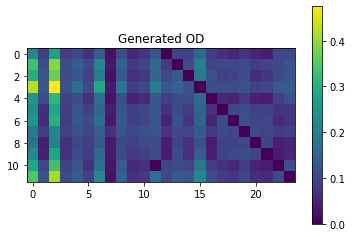

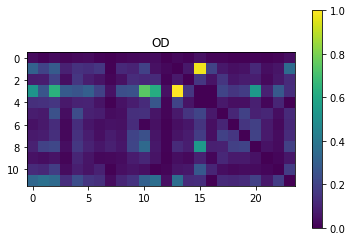

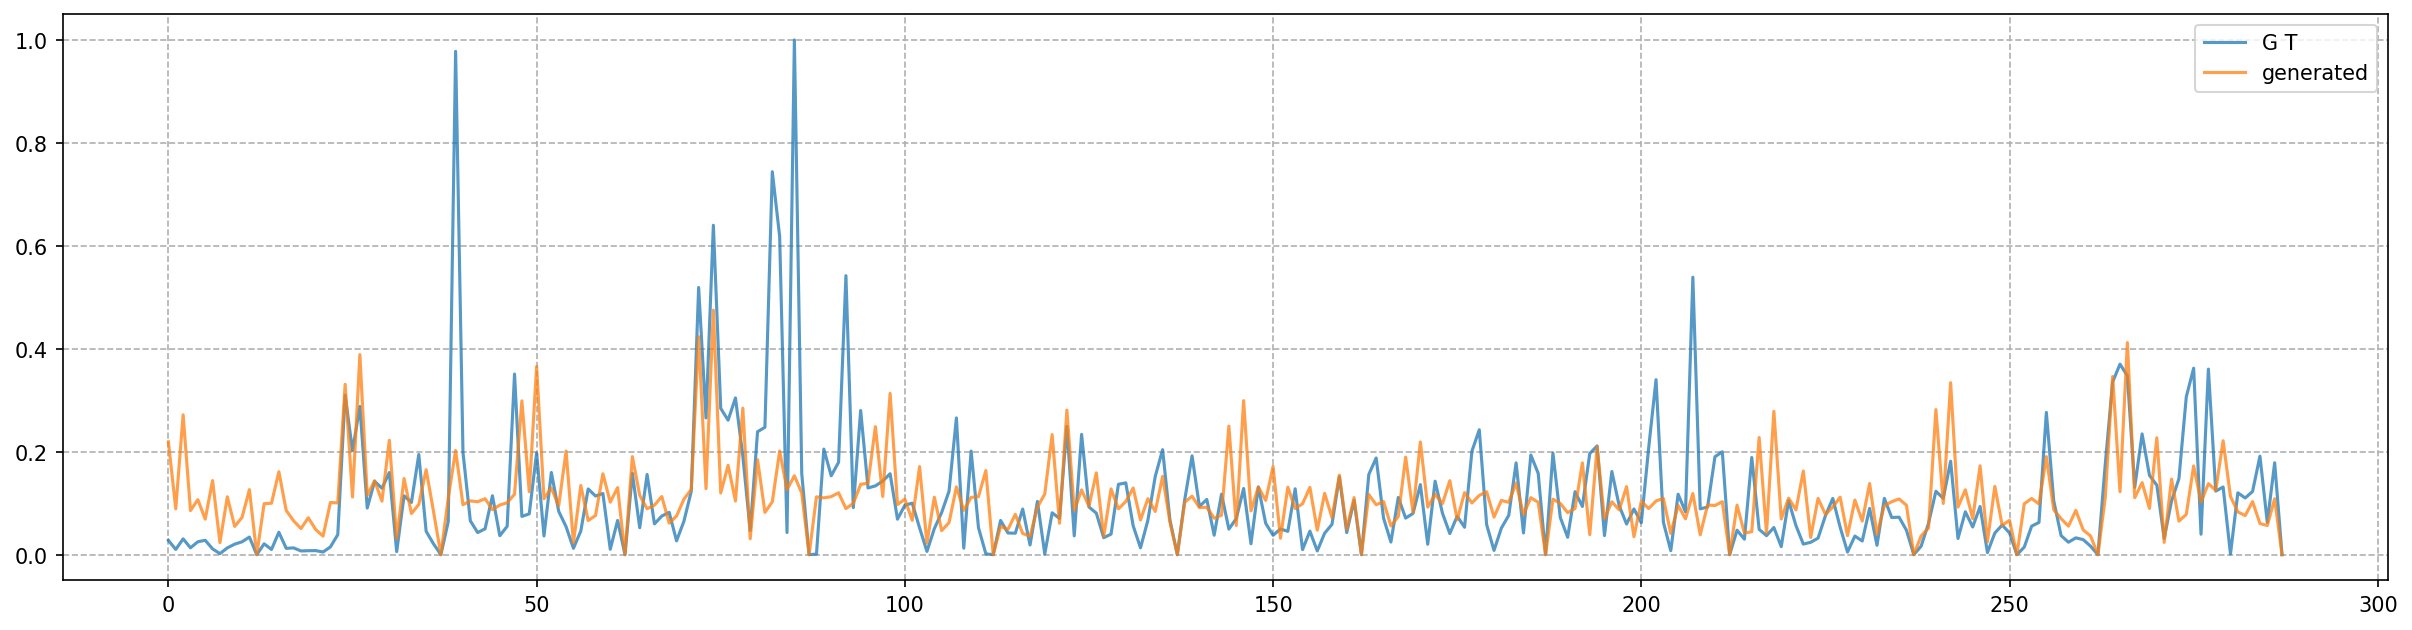

In [497]:
plt.figure()
plt.imshow(gen.reshape(12,24))
plt.title('Generated OD')
plt.colorbar()
plt.figure()
plt.imshow(labels.reshape(12,24))
plt.title('OD')
plt.colorbar()
plt.figure(figsize=[20,5], dpi=150)
plt.plot(range(labels.shape[0]), labels.flatten(), label='G T', alpha=0.75)
plt.plot(range(gen.shape[0]), gen.flatten(), label='generated', alpha=0.75)
# plt.plot(range(gen.shape[0]), gen_up.flatten(), label='generated upper', alpha=0.75)
# plt.plot(range(gen.shape[0]), gen_low.flatten(), label='generated lower', alpha=0.75)
plt.legend()
plt.grid(ls='--')


In [501]:
np.save('./res/vae_labels.npy', labels)
np.save('./res/vae_pred.npy', gen)

# Visualization of OD

In [491]:
import geopandas as gpd

In [492]:
city_coor = CSA_df.iloc[:, :3]
city_coor.head(2)

,Airport,lat,lon
0,ATL,33.640833,-84.427222
1,BOS,42.363611,-71.006111


In [493]:
us_CSA_gpd = gpd.read_file('./data/us_CSA.shp')
us_state_gpd = gpd.read_file('./data/us_state.shp')
data_X_all = us_CSA_gpd.loc[us_CSA_gpd['if_plot']==1]
data_X_all.head(2)

,TotPop,CSA,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageW,E_MedWageW,...,D4C,D4D,D5AR,D5AE,NatWalkInd,INTPTLAT,INTPTLON,CSA_Name,if_plot,geometry
6,6584708,122.0,29300.0,"LaGrange, GA-AL",142257,759558,1449909,2970375,668868,969644,...,-60276.863137,-60268.179268,310871248,224466891,8.498581,33.834001,-84.305803,"Atlanta--Athens-Clarke County--Sandy Springs, ...",1,"POLYGON ((-85.16585 32.80850, -85.16563 32.808..."
13,8200935,148.0,49340.0,"Worcester, MA-CT",349774,1079810,1704849,3823517,825804,1051349,...,-28799.664050,-28642.284283,646668796,596458073,11.342761,42.293282,-71.237945,"Boston-Worcester-Providence, MA-RI-NH-CT",1,"MULTIPOLYGON (((-71.88392 41.32650, -71.88213 ..."


In [494]:
def plot_OD(OD, labels, title, ratio):
    # OD is 1-dimensional data
    try:
        OD = np.array(OD)
    except Exception as e:
        OD = OD.cpu().detach().numpy()
    OD = OD.reshape(12, 24)
    labels = labels.reshape(12, 24)

    fig = plt.figure(figsize=[30, 20], dpi=75)
    ax0 = fig.add_subplot(111)
    ax0.set_title(title)
    ax0.grid(ls='--')

    us_state_gpd.plot(ax=ax0, alpha=0.5, color='blue')
    data_X_all.plot(column='TotPop', ax=ax0, cmap='RdPu')

    low_lon_dest = []
    low_lat_dest = []
    mid_lon_dest = []
    mid_lat_dest = []
    high_lon_dest = []
    high_lat_dest = []
    low_lon_origin = []
    low_lat_origin = []
    mid_lon_origin = []
    mid_lat_origin = []
    high_lon_origin = []
    high_lat_origin = []


    for i in range(OD.shape[0]):
        for j in range(OD.shape[1]):
            trip_OD = OD[i, j]
            trip_label = labels[i, j]

            org = OD_df.index[i+12]
            lon_origin = CSA_df.loc[CSA_df['Airport']==org, 'lon']
            lat_origin = CSA_df.loc[CSA_df['Airport']==org, 'lat']

            dest = OD_df.columns[j]
            lon_dest = CSA_df.loc[CSA_df['Airport']==dest, 'lon']
            lat_dest = CSA_df.loc[CSA_df['Airport']==dest, 'lat']

            if trip_OD-OD.min()<(OD.max()-OD.min())*ratio:
                low_lon_dest.append(lon_dest)
                low_lat_dest.append(lat_dest)
                low_lon_origin.append(lon_origin)
                low_lat_origin.append(lat_origin)
#             elif trip_OD-labels.min()>=(labels.max()-labels.min())*0.2 and trip_OD-labels.min()<(labels.max()-labels.min())*0.4:
#                 mid_lon_dest.append(lon_dest)
#                 mid_lat_dest.append(lat_dest)
#                 mid_lon_origin.append(lon_origin)
#                 mid_lat_origin.append(lat_origin)
            elif trip_OD-OD.min()>=(OD.max()-OD.min())*ratio:
                high_lon_dest.append(lon_dest)
                high_lat_dest.append(lat_dest)
                high_lon_origin.append(lon_origin)
                high_lat_origin.append(lat_origin)


    for i in range(len(low_lon_dest)):
        ax0.plot([low_lon_origin[i], low_lon_dest[i]], [low_lat_origin[i], low_lat_dest[i]], 'b', lw=0.3)

    for i in range(len(mid_lon_dest)):
        ax0.plot([mid_lon_origin[i], mid_lon_dest[i]], [mid_lat_origin[i], mid_lat_dest[i]], 'orange', lw=1)

    for i in range(len(high_lon_dest)):
        ax0.plot([high_lon_origin[i], high_lon_dest[i]], [high_lat_origin[i], high_lat_dest[i]], 'red', lw=1.5)

    # plot airports
    for i in city_coor.index:
        lon = city_coor.loc[i, 'lon']
        lat = city_coor.loc[i, 'lat']
        ax0.plot(lon, lat, '*', color='blue', markersize=15)




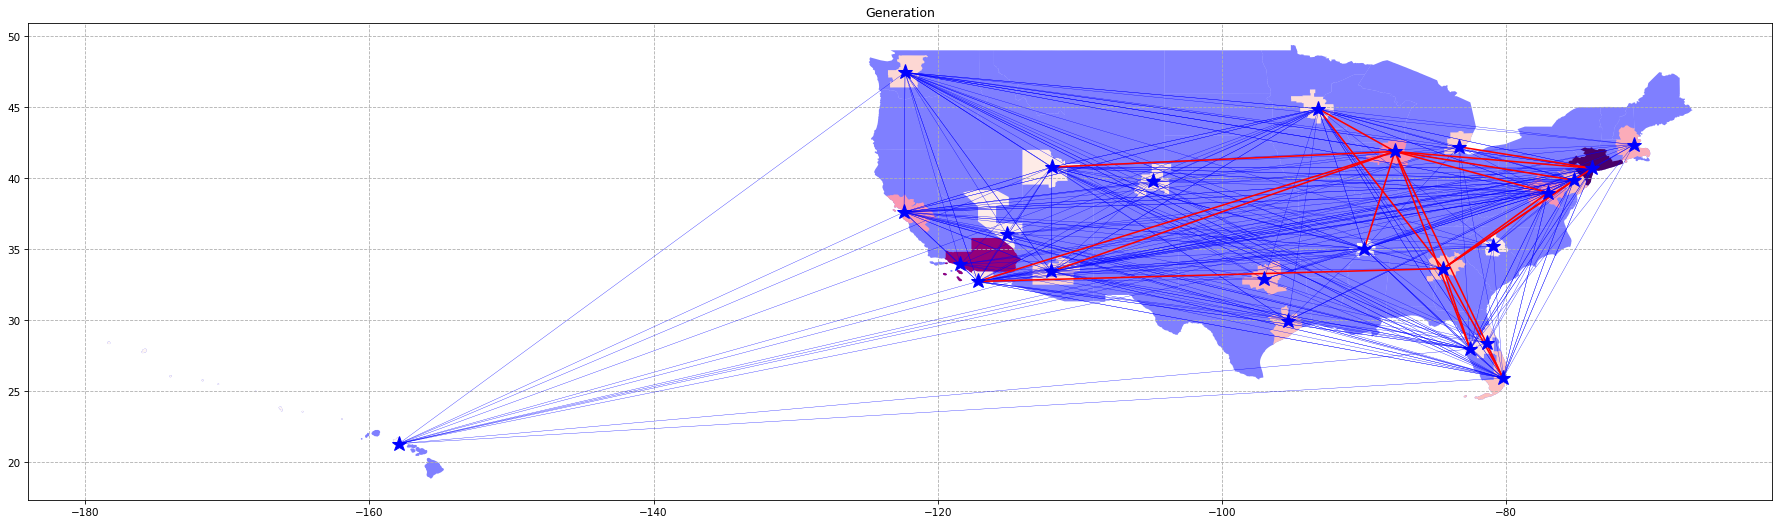

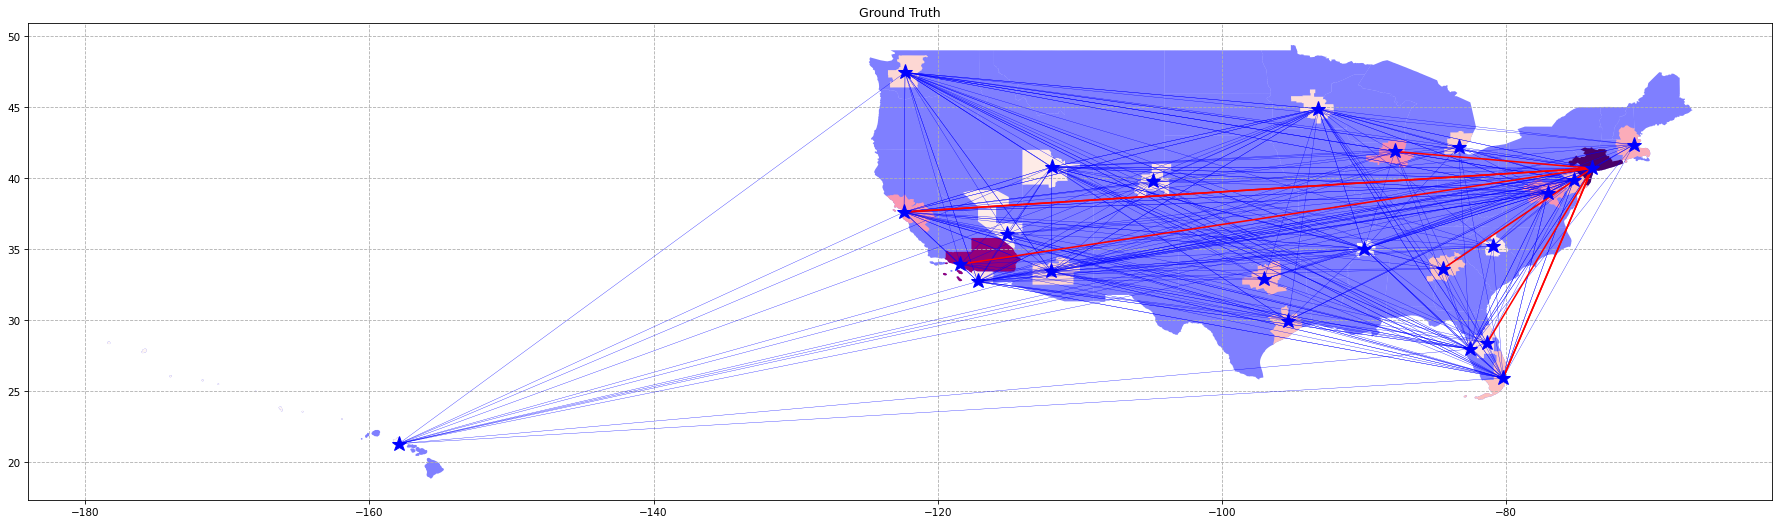

In [495]:
r = 0.5
plot_OD(gen, labels, 'Generation', r)
plot_OD(labels, labels, 'Ground Truth', r)

In [356]:
def plot_OD2(OD, title):
    # OD is 1-dimensional data
    try:
        OD = np.array(OD)
    except Exception as e:
        OD = OD.cpu().detach().numpy()
    OD = OD.reshape(12, 24)

    fig = plt.figure(figsize=[30, 12])
    ax0 = fig.add_subplot(111)
    ax0.set_title(title)
    ax0.grid(ls='--')

    us_state_gpd.plot(ax=ax0, alpha=0.5, color='blue')
    data_X_all.plot(column='TotPop', ax=ax0, cmap='RdPu')
    
    for i in range(OD.shape[0]):
        for j in range(OD.shape[1]):
            trip_OD = OD[i, j]

            org = OD_df.index[i+12]
            lon_origin = CSA_df.loc[CSA_df['Airport']==org, 'lon']
            lat_origin = CSA_df.loc[CSA_df['Airport']==org, 'lat']

            dest = OD_df.columns[j]
            lon_dest = CSA_df.loc[CSA_df['Airport']==dest, 'lon']
            lat_dest = CSA_df.loc[CSA_df['Airport']==dest, 'lat']
            
            c = min(np.sqrt(trip_OD), 1)
            ax0.plot([lon_origin, lon_dest], [lat_origin, lat_dest], lw=10*np.sqrt(trip_OD), color=[c, c/5, c/5])
            
    # plot airports
    for i in city_coor.index:
        lon = city_coor.loc[i, 'lon']
        lat = city_coor.loc[i, 'lat']
        ax0.plot(lon, lat, '*', color='blue', markersize=15)
    return fig
    